In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import time, numpy as np
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/Users/sinhyejin/Desktop/Year4/BT4222/GroupProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Datasets

In [2]:
review_df = pd.read_csv('review_final.csv')
restaurant_df = pd.read_csv('restaurants_final.csv')
restaurant_df.drop('Unnamed: 0', axis=1, inplace=True)
user_df = pd.read_csv('PA_restaurant_user_with_loc.csv')

/var/folders/6m/51l9cwxd4px017cch8f2654r0000gn/T/ipykernel_36085/1325913468.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  user_df = pd.read_csv('PA_restaurant_user_with_loc.csv')


#### Matrix Factorization 

##### Prepare Item Features 

In [3]:
review_df.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783


In [4]:
def create_full_description(df, text_features):
    features = text_features
    df[features] = df[features].fillna('')
    df['editorial_summary'] = df['editorial_summary'].apply(lambda x: x if x.strip() != '' else '')
    df['categories'] = df['categories'].str.replace(',', ' ')
    df.loc[df['editorial_summary'].str.strip() == '', 'editorial_summary'] = (
        df['categories']
    )
    for col in text_features:
        df[col] = df[col].str.replace(',', ' ')
        
    # Combine all into a single description column
    df['description'] = df[text_features]\
        .agg(' '.join, axis=1)\
        .str.replace(r'\s+', ' ', regex=True)\
        .str.strip()
    return df

In [5]:
item_df = restaurant_df.copy() 
text_features = ['categories', 'editorial_summary', 'city']
item_df = create_full_description(item_df, text_features)
item_df.head(2)
# Select Features 
item_df[['business_id', 'description', 'price_level', 'yelp_rating']].head(2)

,business_id,description,price_level,yelp_rating
0,--epgcb7xHGuJ-4PUeSLAw,Restaurants Food Bagels Sandwiches Breakfast &...,1.0,3.0
1,-0FX23yAacC4bbLaGPvyxw,American (Traditional) Restaurants American (T...,3.0,3.5


In [6]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# Apply SBERT embedding to each restaurant description
item_df['sbert_embedding'] = item_df['description'].apply(lambda x: sbert_model.encode(x, show_progress_bar=False))
# Create the matrix of all item embeddings
embedding_matrix = np.vstack(item_df['sbert_embedding'].values)

In [7]:
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(item_df[['price_level', 'yelp_rating']])

# Combine SBERT with numeric features
item_features = np.hstack([embedding_matrix, numeric_features])
# Convert to torch tensor 
item_features_tensor = torch.tensor(item_features, dtype=torch.float32)
item_features_tensor = torch.nan_to_num(item_features_tensor, nan=0.0)

In [8]:
torch.save(item_features_tensor, 'item_features_tensor.pt')

##### Prepare User Features 

In [9]:
user_df.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,"('latitude', 'mean')","('longitude', 'mean')"
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,56,18,232,844,467,467,239,180,39.959457,-75.169912
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,157,251,1847,7054,3131,3131,1521,1946,39.988870,-75.191895


In [10]:
# Select relevant columns
user_features = user_df[['review_count', 'average_stars', 'fans']].values
# Normalize
scaler = MinMaxScaler()
user_features_scaled = scaler.fit_transform(user_features)
# Convert to torch tensor
user_features_tensor = torch.tensor(user_features_scaled, dtype=torch.float32)

In [11]:
torch.save(user_features_tensor, 'user_features_tensor.pt')

In [12]:
import pickle 
user_le = LabelEncoder()
item_le = LabelEncoder()
review_df['user_id'] = user_le.fit_transform(review_df['user_id'])
review_df['business_id'] = item_le.fit_transform(review_df['business_id'])

with open('user_mf_encoder.pkl', 'wb') as f:
    pickle.dump(user_le, f)

with open('item_mf_encoder.pkl', 'wb') as f:
    pickle.dump(item_le, f)

In [13]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.LongTensor(df['user_id'].values)
        self.items = torch.LongTensor(df['business_id'].values)
        self.ratings = torch.FloatTensor(df['stars'].values)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

def create_dataloaders(train_df, test_df, batch_size):

    train_dataset = RatingsDataset(train_df)
    test_dataset = RatingsDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_df = review_df[review_df['date'] < '2021-01-01']
test_df = review_df[review_df['date'] >= '2021-01-01']

train_loader, test_loader = create_dataloaders(train_df, test_df, batch_size=256)

In [14]:
print(f'Train Loader size: {len(train_loader)}')
print(f"Test Loader size: {len(test_loader)}")

Train Loader size: 2992
Test Loader size: 277


In [15]:
class MF(nn.Module):
    def __init__(self, n_users, n_items, user_feat_dim, item_feat_dim, embedding_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, embedding_dim)
        self.item_emb = nn.Embedding(n_items, embedding_dim)

        # Side feature projection layers
        self.user_feat_proj = nn.Linear(user_feat_dim, embedding_dim)
        self.item_feat_proj = nn.Linear(item_feat_dim, embedding_dim)

        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.tensor([0.0]))


        # Initialization
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        nn.init.xavier_uniform_(self.user_feat_proj.weight)
        nn.init.xavier_uniform_(self.item_feat_proj.weight)

    def forward(self, users, items, user_features, item_features):
        # User latent + side
        u_id = self.user_emb(users)
        u_feat = self.user_feat_proj(user_features[users])
        u = u_id + u_feat

        # Item latent + side
        i_id = self.item_emb(items)
        i_feat = self.item_feat_proj(item_features[items])
        i = i_id + i_feat

        # Dot product + bias
        dot = (u * i).sum(1, keepdim=True)
        bias = self.user_bias(users) + self.item_bias(items) + self.global_bias

        return (dot + bias).squeeze(1)  

In [16]:
def train(model, dataloader, optimizer, loss_fn, 
          user_features_tensor, item_features_tensor, 
          device='cpu', epochs=10):
    
    model.to(device)
    user_features_tensor = user_features_tensor.to(device)
    item_features_tensor = item_features_tensor.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for user, item, rating in dataloader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device).unsqueeze(1)

            # Forward pass with side info
            preds = model(user, item, user_features_tensor, item_features_tensor)
            loss = loss_fn(preds, rating)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} | Training Loss: {avg_loss:.4f}")

In [17]:
n_users = review_df['user_id'].nunique()
n_items = review_df['business_id'].nunique()
model = MF(n_users, n_items, user_feat_dim=3, item_feat_dim=386)
### Loaded Trained Model using MF model 
model.load_state_dict(torch.load('MF_model.pth'))
model

MF(
  (user_emb): Embedding(269461, 64)
  (item_emb): Embedding(8069, 64)
  (user_feat_proj): Linear(in_features=3, out_features=64, bias=True)
  (item_feat_proj): Linear(in_features=386, out_features=64, bias=True)
  (user_bias): Embedding(269461, 1)
  (item_bias): Embedding(8069, 1)
)

In [18]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
### Train the model, takes about 20 minutes to run 
### This would give MF model 
# train(model, train_loader, optimizer, loss_fn, user_features_tensor, item_features_tensor, device=device, epochs=10)

In [19]:
torch.save(model.state_dict(), 'MF_model.pth')

#### Evaluation 

In [20]:
@torch.no_grad()
def evaluate(model, dataloader, device, user_features_tensor, item_features_tensor, k=10):
    model.eval()
    preds, actuals = [], []
    user_item_scores = defaultdict(list)

    user_features_tensor = user_features_tensor.to(device)
    item_features_tensor = item_features_tensor.to(device)

    for users, items, ratings in dataloader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)

        raw_outputs = model(users, items, user_features_tensor, item_features_tensor)
        outputs = torch.clamp(raw_outputs, 1.0, 5.0)

        outputs = outputs.cpu().numpy()
        users = users.cpu().numpy()
        items = items.cpu().numpy()
        ratings = ratings.cpu().numpy()

        preds.extend(outputs)
        actuals.extend(ratings)

        for u, i, r, s in zip(users, items, ratings, outputs):
            user_item_scores[u].append((i, s, r))

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    print(f"RMSE: {rmse:.4f}")

    return rmse, preds

In [21]:
rmse, preds = evaluate(model, test_loader, device, user_features_tensor, item_features_tensor,  k=10)

RMSE: 1.5114


In [22]:
test_data = test_df.copy()
test_data.loc[:, 'mf_model_preds'] = preds 
test_data.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars,mf_model_preds
42877,HgEofz6qEQqKYPT7YLA34w,233982,6005,1.0,0,0,0,How does a delivery person from here get lost ...,2021-01-02 00:19:00,63,delivery person get lost not heard google map ...,0,1459,0.811859,0.811859,3.961690
43178,Kxo5d6EOnOE-vERwQf2a1w,16110,3640,5.0,0,0,0,"The service is always good, the employees are ...",2021-01-26 18:01:45,20,service always good employee nice vegan africa...,0,1435,0.814647,4.073237,3.897458


In [23]:
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances, dtype=np.float32)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

In [24]:
def evaluate_ndcg_per_user(test_df, score_col='mf_model_preds', label_col='label_binary', k=10):
    ndcgs = []
    grouped = test_df.groupby("user_id")

    for user, group in grouped:
        group_sorted = group.sort_values(by=score_col, ascending=False)
        relevance = group_sorted[label_col].values
        if len(relevance) == 0:
            continue
        ndcg = ndcg_at_k(relevance, k)
        ndcgs.append(ndcg)

    return np.mean(ndcgs)

In [25]:
test_data['mf_model_preds_binary'] = (test_data['mf_model_preds'] >= 4).astype(int)
true_labels = test_data['stars'].apply(lambda x: 1 if x>=4 else 0).values
test_data['label_binary'] = true_labels
accuracy = np.mean(test_data['mf_model_preds_binary']==true_labels)
ndcg_10 = evaluate_ndcg_per_user(test_data)
print(f'Accuracy rate is: {accuracy :.4f}')
print(f'NDCG@10 is: {ndcg_10 :.4f}')

Accuracy rate is: 0.3668
NDCG@10 is: 0.6604


#### Further Analysis
- look for individual user's past restauratns and recommended restaurants

In [26]:
@torch.no_grad()
def predict_for_user(model, user_idx, all_item_indices, user_features_tensor, item_features_tensor, device='cpu', top_k=10):
    model.eval()
    
    user_tensor = torch.tensor([user_idx] * len(all_item_indices), dtype=torch.long).to(device)
    item_tensor = torch.tensor(all_item_indices, dtype=torch.long).to(device)

    user_features_tensor = user_features_tensor.to(device)
    item_features_tensor = item_features_tensor.to(device)

    # Predict scores for all items for this user
    scores = model(user_tensor, item_tensor, user_features_tensor, item_features_tensor)
    scores = torch.clamp(scores, 1, 5)
    scores = scores.cpu().numpy()

    # Rank items by score
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    top_items = [(all_item_indices[i], scores[i]) for i in ranked_indices]

    return top_items

In [27]:
user_idx = 156637

top_recs = predict_for_user(
    model=model,
    user_idx=user_idx,  
    all_item_indices=list(range(item_features_tensor.shape[0])),
    user_features_tensor=user_features_tensor,
    item_features_tensor=item_features_tensor,
    device=device,
    top_k=10
)

item_indices = [item_idx for item_idx, _ in top_recs]
original_business_ids = item_le.inverse_transform(item_indices)
original_user_id = user_le.inverse_transform([user_idx])[0]

print("User: ", original_user_id)
decoded_recs = list(zip(original_business_ids, [score for _, score in top_recs]))

for business_id, score in decoded_recs:
    print(f"Restaurant ID: {business_id} → Predicted Score: {score:.4f}")

User:  _BcWyKQL16ndpBdggh2kNA
Restaurant ID: rKe7iEiqe8TVqvwZLdlhRA → Predicted Score: 4.2842
Restaurant ID: OAWa1WML2V1ZLJGD6V3nBQ → Predicted Score: 4.2784
Restaurant ID: UeC_Vq0rxvrIqVRQxLuLPw → Predicted Score: 4.2362
Restaurant ID: OTwwIvLkrS0zc8f1lNRstw → Predicted Score: 4.2146
Restaurant ID: luv3Y2AjoOhxYRY_u5tRJA → Predicted Score: 4.2090
Restaurant ID: m7aQVu6auR4N57gqYiwLwQ → Predicted Score: 4.2058
Restaurant ID: TJhQ9wS_nuLE383nfWXnqw → Predicted Score: 4.2021
Restaurant ID: mFXzS0ogBF8fc_mMMGSLDA → Predicted Score: 4.1937
Restaurant ID: qWretbXJ-inUy1ywE7r3xQ → Predicted Score: 4.1910
Restaurant ID: xK_lHWT8n5y_Cy3q-hWA_g → Predicted Score: 4.1910


In [28]:
recommended_business_ids = [bid for bid, _ in decoded_recs]
recommended_business_ids

['rKe7iEiqe8TVqvwZLdlhRA',
 'OAWa1WML2V1ZLJGD6V3nBQ',
 'UeC_Vq0rxvrIqVRQxLuLPw',
 'OTwwIvLkrS0zc8f1lNRstw',
 'luv3Y2AjoOhxYRY_u5tRJA',
 'm7aQVu6auR4N57gqYiwLwQ',
 'TJhQ9wS_nuLE383nfWXnqw',
 'mFXzS0ogBF8fc_mMMGSLDA',
 'qWretbXJ-inUy1ywE7r3xQ',
 'xK_lHWT8n5y_Cy3q-hWA_g']

In [29]:
user_visited_rest_ids = review_df.loc[review_df['user_id']==user_idx]['business_id']
user_visited_rest_ids_original = item_le.inverse_transform(user_visited_rest_ids)

In [30]:
restaurant_df.loc[restaurant_df['business_id'].isin(user_visited_rest_ids_original)][['name', 'city', 'categories']]

,name,city,categories
8,World Cafe Live,Philadelphia,"Nightlife, Arts & Entertainment, Restaurants, ..."
16,Au Bon Pain,Philadelphia,"Bakeries, Restaurants, Food, Cafes"
28,Luberto's Brickoven Pizza,Dublin,"Restaurants, Pizza, Italian"
30,Smokey Joe's Tavern,Philadelphia,"Bars, Dive Bars, Pizza, Nightlife, Restaurants"
40,Bagel Barrel,Doylestown,"Bagels, Restaurants, Food"
...,...,...,...
8036,Philly Pretzel Factory,Philadelphia,"Food, Pretzels, Hot Dogs, Bakeries, Restaurant..."
8037,Bolton's Farm Market,Silverdale,"Home & Garden, Specialty Food, Delis, Restaura..."
8045,Lee's Hoagie House,Norristown,"Sandwiches, Cheesesteaks, Restaurants, Delis, ..."
8053,Panera Bread,Wayne,"Sandwiches, Food, Breakfast & Brunch, Salad, S..."


In [31]:
restaurant_df.loc[restaurant_df['business_id'].isin(recommended_business_ids)][['name', 'city', 'categories']]

,name,city,categories
3169,Middle Child,Philadelphia,"Coffee & Tea, Sandwiches, Delis, Diners, Food,..."
3210,Dasiwa,Philadelphia,"Sushi Bars, Restaurants"
3794,Major Wing Lee Grocery Market,Philadelphia,"Restaurants, Delis, Food, Grocery, Sandwiches"
3969,Wing Hut,Woodlyn,"Sandwiches, Restaurants, Cajun/Creole, Salad, ..."
6316,The Couch Tomato Cafe,Philadelphia,"Italian, Restaurants, Sandwiches, Food Deliver..."
6340,Hong Kong King Buffet,Feasterville Trevose,"Restaurants, Chinese"
6362,Tasty Table Catering,Berwyn,"Food Delivery Services, Event Planning & Servi..."
6928,Baan Thai Sabaidee,West Chester,"Restaurants, Thai"
7029,Burger King,Morrisville,"Fast Food, Restaurants, Burgers"
7736,China Palace,Norristown,"Restaurants, Chinese"


#### Hit@10

In [32]:
review_df = pd.read_csv('review_final.csv')
train_df = review_df[review_df['date'] < '2021-01-01']
test_df = review_df[review_df['date'] >= '2021-01-01']

In [33]:
@torch.no_grad()
def get_mf_recommendation(model, user_idx, all_item_indices, user_features_tensor, item_features_tensor, device='cpu', top_k=10):
    model.eval()
    
    user_idx = user_le.transform([user_idx])[0]
    user_tensor = torch.tensor([user_idx] * len(all_item_indices), dtype=torch.long).to(device)
    item_tensor = torch.tensor(all_item_indices, dtype=torch.long).to(device)

    user_features_tensor = user_features_tensor.to(device)
    item_features_tensor = item_features_tensor.to(device)

    # Predict scores for all items for this user
    scores = model(user_tensor, item_tensor, user_features_tensor, item_features_tensor)
    scores = torch.clamp(scores, 1, 5)
    scores = scores.cpu().numpy()

    # Rank items by score
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    top_items = [(all_item_indices[i], scores[i]) for i in ranked_indices]
    item_indices = [item_idx for item_idx, _ in top_items]
    original_business_ids = item_le.inverse_transform(item_indices)
    top_recs = pd.DataFrame({
        'business_id': original_business_ids,
    })
    return top_recs

all_item_indices=list(range(item_features_tensor.shape[0]))
def get_recommendation(user_id, k):
    recommendation = get_mf_recommendation(model, user_id, all_item_indices, user_features_tensor, item_features_tensor, device='cpu', top_k=k)
    return recommendation

In [35]:
import random
import matplotlib.pyplot as plt 
def hits_at_k(user_id, test_df, recommend_func, k=10):
    # true_item = test_df.loc[test_df['user_id'] == user_id]['business_id'].iloc[0]
    true_items = test_df[(test_df['user_id'] == user_id) &
                         (test_df['stars'] >= 3) # Hit rate should consider if the user liked the restaurant
                         ]['business_id'].tolist()
    recommended = recommend_func(user_id, k)
    recommended_items = recommended['business_id'].tolist()
    return int(any(item in recommended_items for item in true_items))

def get_hit_rate_for_n_users(users, recommend_func):
    total_hits = 0
    for user in users:
        hits = hits_at_k(user, test_df, recommend_func, k=10)
        if hits != 0:
            total_hits += 1
    return total_hits / len(users)

def plot_hit_rate_vs_users(test_df, max_users, step, recommend_func):
    # Step 1: Get users sorted by interaction count descending
    user_interaction_counts = (
        test_df.groupby('user_id')
        .size()
        .sort_values(ascending=False)
    )
    sorted_users = user_interaction_counts.index.tolist()

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = sorted_users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, recommend_func, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()


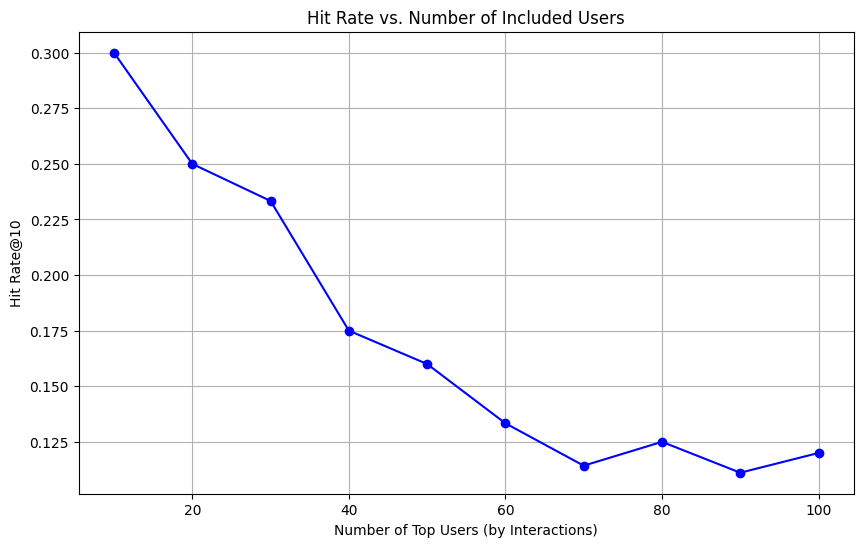

In [36]:
### SORTED BY FREQUENTLY-INTERACTED USERS 
plot_hit_rate_vs_users(test_df, max_users=100, step=10, recommend_func=get_recommendation)

In [38]:
def plot_hit_rate_vs_users_random(test_df, max_users, step, recommend_func):
    # Step 1: Get unique users and shuffle
    unique_users = test_df['user_id'].unique().tolist()
    random.shuffle(unique_users)

    # Ensure we don't exceed the available number of users
    max_users = min(max_users, len(unique_users))

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = unique_users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, recommend_func, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='g')
    plt.xlabel("Number of Random Users")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Randomly Selected Users")
    plt.grid(True)
    plt.show()

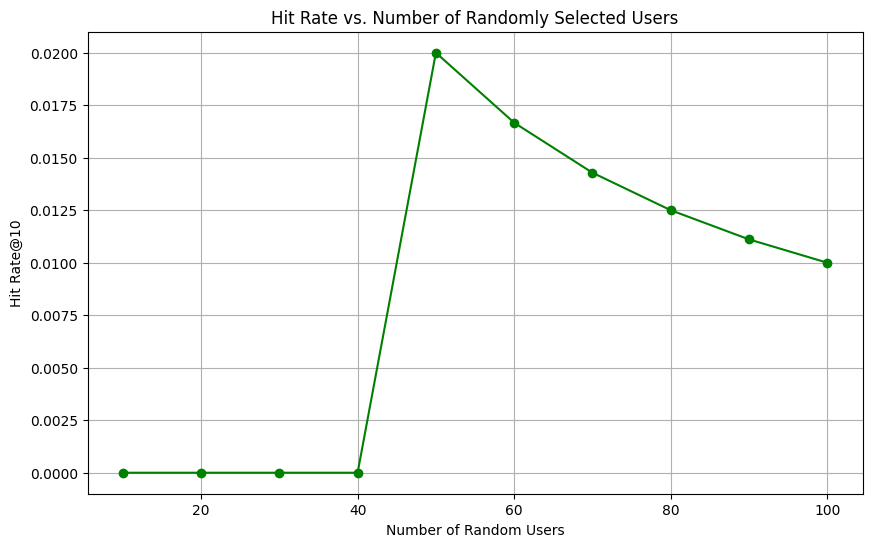

In [41]:
### RANDOMLY PICKED (TEST SET)
random.seed(42)
plot_hit_rate_vs_users_random(test_df, max_users=100, step=10, recommend_func=get_recommendation)

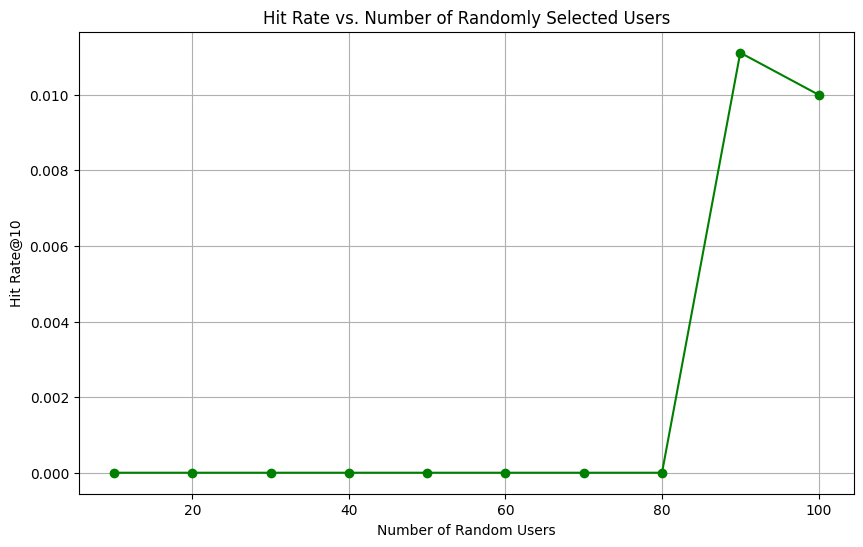

In [42]:
### RANDOMLY PICKED (TRAIN SET)
plot_hit_rate_vs_users_random(train_df, max_users=100, step=10, recommend_func=get_recommendation)